In [7]:
import torch
from torch import nn
from torchvision import models
from tqdm import tqdm
from sklearn.model_selection import KFold
import cv2
import random
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import albumentations as A
from torch.utils.data import Dataset,DataLoader
import os
import shutil
from datetime import datetime
from torch.autograd import Variable
from math import floor, ceil, sqrt, exp
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List, Optional
from PIL import Image
from torch import Tensor
import glob
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_recall_curve
from torchvision.models import vit_b_16, vit_l_16
from torchvision.models.vision_transformer import ViT_B_16_Weights
import torch.nn.functional as F
from typing import Dict, List
import torch.optim as optim
from torchvision import models
from albumentations import Compose, Resize, Normalize
import torchvision.transforms as T
import random
from torch.utils.data import random_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,recall_score, f1_score, jaccard_score,
                            matthews_corrcoef, balanced_accuracy_score,cohen_kappa_score)

##### cuda

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
# torch.cuda.empty_cache()

In [10]:
# !pip install GPUtil

# from GPUtil import showUtilization as gpu_usage
# gpu_usage()      

In [11]:
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()                             

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()     

### Dataset

In [12]:
class LEVIRCDPlus(torch.utils.data.Dataset):
    def __init__(self, root, split, transforms, max_files = None) -> None: 
        self.root = root
        self.split = split
        self.transforms = transforms
        self.max_files = max_files

        self.files = self._load_files(self.root, self.split, self.max_files)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        files = self.files[index]
        
        image1 = Image.open(files['image1'])
        image2 = Image.open(files['image2'])
        mask = Image.open(files['mask'])

        if self.transforms is not None:
            transformed = self.transforms(image=np.array(image1), image0=np.array(image2), mask=np.array(mask))
            image1 = transformed['image'] / 255.0
            image2 = transformed['image0'] / 255.0
            mask = transformed['mask'] / 255.0
        else:
            image1 = torch.tensor(np.array(image1)).permute(2, 0, 1).float() / 255.0 
            image2 = torch.tensor(np.array(image2)).permute(2, 0, 1).float() / 255.0
            mask = torch.tensor(np.array(mask)).float().unsqueeze(0) / 255.0

        x = torch.stack([image1, image2], dim=0)
        return dict(x=x, mask=mask)

    def __len__(self) -> int:
        return len(self.files)

    def _load_files(self, root, split, max_files = None) -> List[Dict[str, str]]:
        files = []
        images = glob.glob(os.path.join(root, split, 'A', "*.png"))
        images = sorted([os.path.basename(image) for image in images])

        if max_files is not None:
            images = images[:max_files]

        for image in images:
            image1 = os.path.join(root, split, 'A', image)
            image2 = os.path.join(root, split, 'B', image)
            mask = os.path.join(root, split, 'label', image)
            files.append(dict(image1=image1, image2=image2, mask=mask))
        return files

In [82]:
train_transform = A.Compose([
    ToTensorV2()
], additional_targets={'image0': 'image'})

test_transform = A.Compose([
    ToTensorV2()
], additional_targets={'image0': 'image'})


train_dset = LEVIRCDPlus(
    root="/kaggle/input/s2looking/LEVIR-CD+/LEVIR-CD+",
    split='train', 
    transforms = train_transform
)

test_dset = LEVIRCDPlus(
    root="/kaggle/input/s2looking/LEVIR-CD+/LEVIR-CD+",
    split='test',
    transforms = test_transform
)

In [83]:
print(f"Train: {len(train_dset)}")
print('x: ', train_dset[0]['x'].shape)
print('mask: ', train_dset[0]['mask'].shape)

print(f"Test: {len(test_dset)}")
print('x: ', test_dset[0]['x'].shape)
print('mask: ', test_dset[0]['mask'].shape)

Train: 637
x:  torch.Size([2, 3, 1024, 1024])
mask:  torch.Size([1024, 1024])
Test: 348
x:  torch.Size([2, 3, 1024, 1024])
mask:  torch.Size([1024, 1024])


##### Visualization

In [15]:
def visualize_sample(dataset,i=0):
    sample = dataset[i]
    image1 = sample['x'][0].permute(1, 2, 0).numpy()
    image2 = sample['x'][1].permute(1, 2, 0).numpy()
    mask = sample['mask'].squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(image1)
    axs[0].set_title('Image 1')
    axs[0].axis('off')

    axs[1].imshow(image2)
    axs[1].set_title('Image 2')
    axs[1].axis('off')

    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title('Mask')
    axs[2].axis('off')

    plt.show()

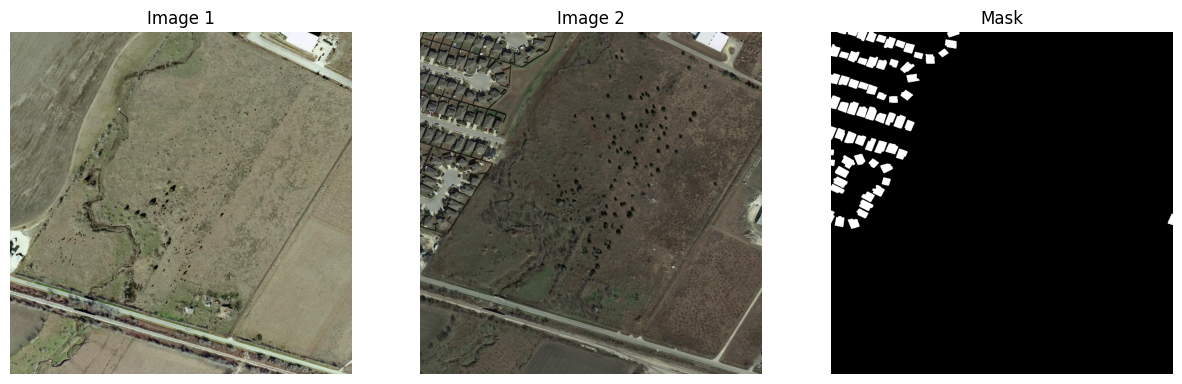

In [16]:
visualize_sample(train_dset,2)

### ChangeDetection with ViT

##### vit_b_16

In [17]:
class ChangeDetection(nn.Module):
    def __init__(self, num_classes=1):
        super(ChangeDetection, self).__init__()

        self.classes = num_classes
        self.vit = vit_b_16(weights='DEFAULT')  #IMAGENET1K_SWAG_E2E_V1
        self.vit.heads = nn.Identity() #without classification head
        #vit includes transforms resize from 224, interpolation, rescale, normalized using mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

        self.resize = T.Resize((224, 224))
        self.decoder = self.upsampling(num_classes)

    def encoder(self, x):
        x = self.resize(x)
        features = self.vit(x)
        return features
        
    def upsampling(self, num_classes):
        num_classes = self.classes
        vit_output_channels = 768
        return nn.Sequential(
            nn.ConvTranspose2d(vit_output_channels, 512, kernel_size=4, stride=2, padding=1),  #[B, 512, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  #[B, 256, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  #[B, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   #[B, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    #[B, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    #[B, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_classes, kernel_size=4, stride=2, padding=1)  #[B, 1, 128, 128]
        )
        return upsampling

    def combine_features(self, features1, features2):
        return features1 / (features2 + 1e-8)
        
        # rerurn (features1*(1-features2))+((1-features1)*features2)

        # return (features1 - features2) / (features1 + features2 + 1e-8)

    def decode(self, combined_features):
        output = self.decoder(combined_features) 
        output = F.interpolate(output, size=(1024, 1024), mode='bilinear', align_corners=False)
        output = torch.sigmoid(output)
        return output.squeeze(1) 
        
    def forward(self, x):
        x1 = x[:, 0, :, :, :] 
        x2 = x[:, 1, :, :, :] 

        features1 = self.encoder(x1)
        features2 = self.encoder(x2)

        combined_features = self.combine_features(features1, features2)
        combined_features = combined_features.unsqueeze(-1).unsqueeze(-1)
        
        output = self.decode(combined_features)
        output = output.squeeze(1)
        
        return output

##### vit_l_16

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as T
from timm import create_model 

class ChangeDetection(nn.Module):
    def __init__(self, num_classes=1):
        super(ChangeDetection, self).__init__()

        self.classes = num_classes
        self.vit = create_model('vit_large_patch16_224', pretrained=True)
        self.vit.head = nn.Identity() 
        
        self.resize = T.Resize((224, 224))
        self.decoder = self.upsampling(num_classes)

    def encoder(self, x):
        x = self.resize(x)
        features = self.vit.forward_features(x)
        return features  # [B, 197, 1024]

    def upsampling(self, num_classes):
        vit_output_channels = 1024 
        return nn.Sequential(
            nn.ConvTranspose2d(vit_output_channels, 512, kernel_size=4, stride=2, padding=1),  #[B, 512, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  #[B, 256, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  #[B, 128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   #[B, 64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    #[B, 32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    #[B, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_classes, kernel_size=4, stride=2, padding=1)  #[B, num_classes, 128, 128]
        )

    def combine_features(self, features1, features2):
        features1 = features1[:, 1:, :]
        features2 = features2[:, 1:, :]
        
        combined_features = features1.mean(dim=1) / (features2.mean(dim=1) + 1e-6)
        combined_features = combined_features.unsqueeze(-1).unsqueeze(-1)
        
        return combined_features

    def decode(self, combined_features):
        output = self.decoder(combined_features)
        output = F.interpolate(output, size=(1024, 1024), mode='bilinear', align_corners=False)
        output = torch.sigmoid(output)
        return output.squeeze(1)

    def forward(self, x):
        x1 = x[:, 0, :, :, :] 
        x2 = x[:, 1, :, :, :] 

        features1 = self.encoder(x1) 
        features2 = self.encoder(x2) 

        combined_features = self.combine_features(features1, features2)
        output = self.decode(combined_features)
        
        return output


##### Train model

In [19]:
def train_model(model, train_loader, optimizer, criterion=nn.BCELoss(), num_epochs=15, device='cuda'):
    model = model
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            inputs = batch['x'].to(device)
            labels = batch['mask'].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

In [20]:
def reset_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        m.reset_parameters()
        
def train_model_with_cross_validation(model, dataset, optimizer, criterion, num_epochs=10, k_folds=5, device='cuda'):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=4, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=4, shuffle=False)

        model.apply(reset_weights) 
        optimizer.zero_grad()
        
        for epoch in range(num_epochs):
            model.train() 
            running_loss = 0.0

            for batch in train_loader:
                inputs = batch['x'].to(device)
                labels = batch['mask'].to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
        
        model.eval()  
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['x'].to(device)
                labels = batch['mask'].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"Fold {fold + 1}, Validation Loss: {avg_val_loss}")
        fold_results.append(avg_val_loss)

    avg_loss = sum(fold_results) / k_folds
    print('Average Loss: ', avg_loss)

    return fold_results

In [21]:
train_loader = DataLoader(train_dset, shuffle = True)
val_loader = DataLoader(val_dset, shuffle = False)
test_loader = DataLoader(test_dset)

In [25]:
model = ChangeDetection(num_classes=1).to(device)
criterion = nn.BCELoss()  #BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [26]:
#vit_l_16 division
train_model_with_cross_validation(model, train_dset, optimizer, criterion, num_epochs=3, k_folds=5, device=device)

Fold 1/5
Epoch 1/3, Loss: 0.27411188746918924
Epoch 2/3, Loss: 0.20596418145578355
Epoch 3/3, Loss: 0.1933372758794576
Fold 1, Validation Loss: 0.20506392396055162
Fold 2/5
Epoch 1/3, Loss: 0.1920279610203579
Epoch 2/3, Loss: 0.19313011650228873
Epoch 3/3, Loss: 0.20076412505295593
Fold 2, Validation Loss: 0.20107350684702396
Fold 3/5
Epoch 1/3, Loss: 0.19812950209598057
Epoch 2/3, Loss: 0.20118761484627612
Epoch 3/3, Loss: 0.2019766346202232
Fold 3, Validation Loss: 0.1837962016579695
Fold 4/5
Epoch 1/3, Loss: 0.19922681496245787
Epoch 2/3, Loss: 0.1978727805253584
Epoch 3/3, Loss: 0.1983065880194772
Fold 4, Validation Loss: 0.1743027459597215
Fold 5/5
Epoch 1/3, Loss: 0.19174959170049988
Epoch 2/3, Loss: 0.1905674404115416
Epoch 3/3, Loss: 0.19316142975003459
Fold 5, Validation Loss: 0.19510785909369588
Average Loss: 0.1918688475037925


[0.20506392396055162,
 0.20107350684702396,
 0.1837962016579695,
 0.1743027459597215,
 0.19510785909369588]

In [27]:
torch.save(model.state_dict(), "model.pth") #division

In [ ]:
model2 = ChangeDetection(num_classes=1).to(device)
model2.load_state_dict(torch.load("/kaggle/input/model/pytorch/default/1/model.pth", weights_only=True))
model2.eval()

### Evaluate model

In [28]:
def evaluate_model(model, test_loader):
    model.eval() 
    total_loss = 0.0
    with torch.no_grad():
        for i in range(len(test_loader)):
            images = test_loader.dataset[i]['x'].unsqueeze(0).to(device)  
            masks = test_loader.dataset[i]['mask'].unsqueeze(0).to(device).float() / 255.0  
            outputs = model(images)
            loss = criterion(outputs, masks) 
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Average Test Loss: {avg_loss:.4f}')

In [29]:
#division
evaluate_model(model, test_loader)

Average Test Loss: 0.0430


In [25]:
#multiply
evaluate_model(model2, test_loader)

Average Test Loss: 0.0536


In [62]:
def find_threshold(y_true, y_pred,print_=False):
    precision, recall, thresholds = precision_recall_curve(y_true.ravel(), y_pred.ravel())
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9) 

    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    best_f1 = f1_scores[best_threshold_index]

    if(print_):
        print(f'Best Threshold: {best_threshold}')
        print(f'Best F1 Score: {best_f1}')
    return best_threshold, best_f1

def draw(output_binary,mask,image):
    output_binary = output_binary.squeeze(0) 
    mask = mask.squeeze(0) 
    image = image.squeeze(0)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title('Original T1')
    plt.imshow(image[0].cpu().numpy().transpose(1, 2, 0)) 
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Original T2')
    plt.imshow(image[1].cpu().numpy().transpose(1, 2, 0)) 
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('True Mask')
    plt.imshow(mask.cpu(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Predicted Mask (Thresholded)')
    plt.imshow(output_binary.cpu(), cmap='gray')
    plt.axis('off')

    plt.show()

In [61]:
def compute_metrics(true_mask, pred_mask,print_=False):
    true_mask = true_mask.flatten().cpu().numpy()
    pred_mask = pred_mask.flatten().cpu().numpy()

    cm = confusion_matrix(true_mask, pred_mask)

    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    accuracy = accuracy_score(true_mask, pred_mask)
    precision = precision_score(true_mask, pred_mask, zero_division=1)
    recall = recall_score(true_mask, pred_mask, zero_division=1)
    f1 = f1_score(true_mask, pred_mask, zero_division=1)
    iou = jaccard_score(true_mask, pred_mask, zero_division=1)
    mcc = matthews_corrcoef(true_mask, pred_mask)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_accuracy = balanced_accuracy_score(true_mask, pred_mask)
    kappa = cohen_kappa_score(true_mask, pred_mask)

    if (print_):
        print('Confusion Matrix:\n', cm)
        print('Metrics:')
        print('Accuracy: ', accuracy)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1 Score: ', f1)
        print('IoU: ', iou)
        print('MCC: ', mcc)
        print('Specificity: ', specificity)
        print('Balanced Accuracy: ', balanced_accuracy)
        print('Cohen\'s Kappa: ', kappa)

    return accuracy, precision, recall, f1, iou, mcc, specificity, balanced_accuracy, kappa

In [45]:
def evaluate_single_image(model, image, mask):
    model.eval() 
    
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  
        mask = mask.unsqueeze(0).to(device)

        output = model(image) 
    
        output_flat = output.view(-1).cpu().numpy()  
        mask_flat = (mask.view(-1).cpu().numpy() > 0).astype(np.float32) 

        best_threshold, best_f1 = find_threshold(mask_flat, output_flat, True)
        
        # best_threshold = best_threshold
        output_binary = (output > best_threshold).int()
        print(output_binary)

        output_binary = output_binary.squeeze(0) 
        # print(output_binary.shape)
        mask = mask.squeeze(0) 
        image = image.squeeze(0)

        draw(output_binary,mask,image)

        compute_metrics(mask,output_binary,print_=True)

Best Threshold: -3.146188974380493
Best F1 Score: 0.23638409005982194
torch.return_types.min(
values=tensor([False, False, False,  ..., False, False, False], device='cuda:0'),
indices=tensor([59, 59, 59,  ..., 14, 14, 14], device='cuda:0'))


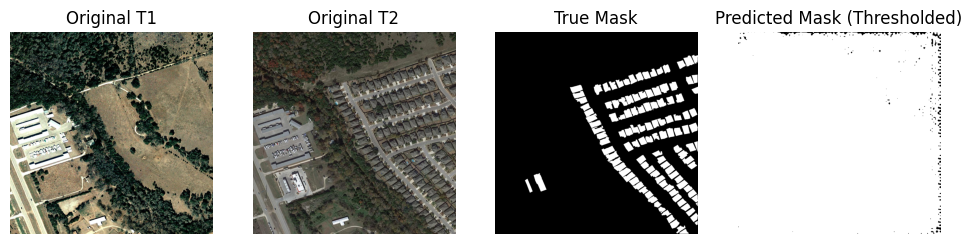

In [43]:
#division
first_image, first_mask = test_dset[0]['x'], test_dset[0]['mask'] 
evaluate_single_image(model, first_image, first_mask)

tensor([[[-2.0627, -2.0627, -2.0627,  ..., -0.6430, -0.6430, -0.6430],
         [-2.0627, -2.0627, -2.0627,  ..., -0.6430, -0.6430, -0.6430],
         [-2.0627, -2.0627, -2.0627,  ..., -0.6430, -0.6430, -0.6430],
         ...,
         [-0.7118, -0.7118, -0.7118,  ..., -0.6328, -0.6328, -0.6328],
         [-0.7118, -0.7118, -0.7118,  ..., -0.6328, -0.6328, -0.6328],
         [-0.7118, -0.7118, -0.7118,  ..., -0.6328, -0.6328, -0.6328]]],
       device='cuda:0')
tensor([[[0.1128, 0.1128, 0.1128,  ..., 0.3446, 0.3446, 0.3446],
         [0.1128, 0.1128, 0.1128,  ..., 0.3446, 0.3446, 0.3446],
         [0.1128, 0.1128, 0.1128,  ..., 0.3446, 0.3446, 0.3446],
         ...,
         [0.3292, 0.3292, 0.3292,  ..., 0.3469, 0.3469, 0.3469],
         [0.3292, 0.3292, 0.3292,  ..., 0.3469, 0.3469, 0.3469],
         [0.3292, 0.3292, 0.3292,  ..., 0.3469, 0.3469, 0.3469]]],
       device='cuda:0')
Best Threshold: 0.00658955005928874
Best F1 Score: 0.24005874680564815
torch.return_types.min(
values=te

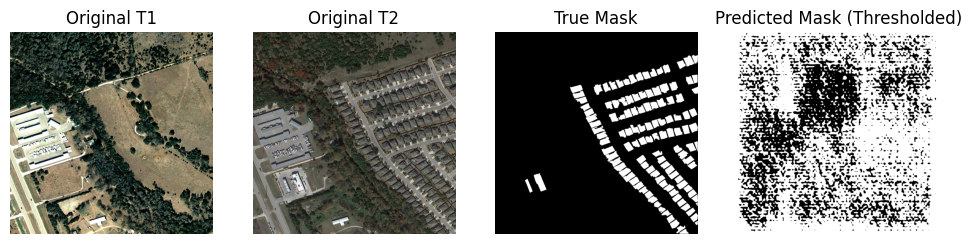

In [28]:
#multiply
first_image, first_mask = test_dset[0]['x'], test_dset[0]['mask'] 
evaluate_single_image(model2, first_image, first_mask)

55
tensor([[[0.1317, 0.1317, 0.1317,  ..., 0.1574, 0.1574, 0.1574],
         [0.1317, 0.1317, 0.1317,  ..., 0.1574, 0.1574, 0.1574],
         [0.1317, 0.1317, 0.1317,  ..., 0.1574, 0.1574, 0.1574],
         ...,
         [0.2286, 0.2286, 0.2286,  ..., 0.2448, 0.2448, 0.2448],
         [0.2286, 0.2286, 0.2286,  ..., 0.2448, 0.2448, 0.2448],
         [0.2286, 0.2286, 0.2286,  ..., 0.2448, 0.2448, 0.2448]]],
       device='cuda:0')
Best Threshold: 0.029621059074997902
Best F1 Score: 0.015072232295458801
tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], device='cuda:0', dtype=torch.int32)


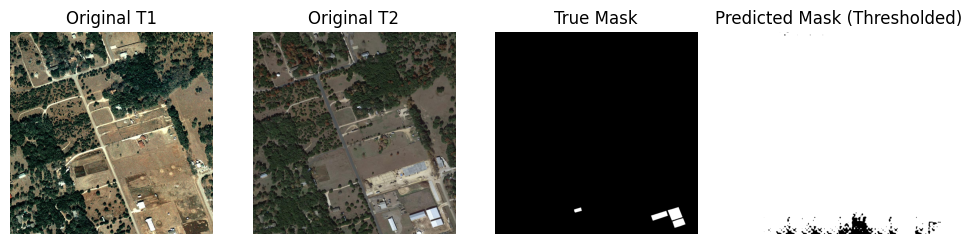

Confusion Matrix:
[[  14512 1026182]
 [     31    7851]]
Metrics:
Accuracy: 0.0213
Precision: 0.0076
Recall: 0.9961
F1 Score: 0.0151
IoU: 0.0076
MCC: 0.0074
Specificity: 0.0139
Balanced Accuracy: 0.5050
Cohen's Kappa: 0.0002


In [100]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

17
Best Threshold: 0.05547602102160454
Best F1 Score: 0.06567483504111225
tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], device='cuda:0', dtype=torch.int32)


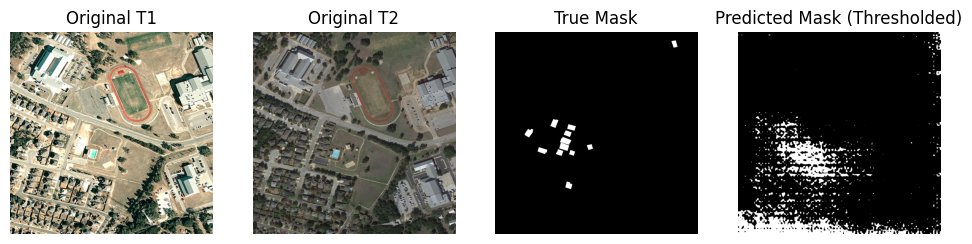

Confusion Matrix:
[[941897  95476]
 [  7582   3621]]
Metrics:
Accuracy: 0.9017
Precision: 0.0365
Recall: 0.3232
F1 Score: 0.0657
IoU: 0.0339
MCC: 0.0812
Specificity: 0.9080
Balanced Accuracy: 0.6156
Cohen's Kappa: 0.0474


In [39]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

151
Best Threshold: 0.03997097909450531
Best F1 Score: 0.26357798077255545
tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], device='cuda:0', dtype=torch.int32)


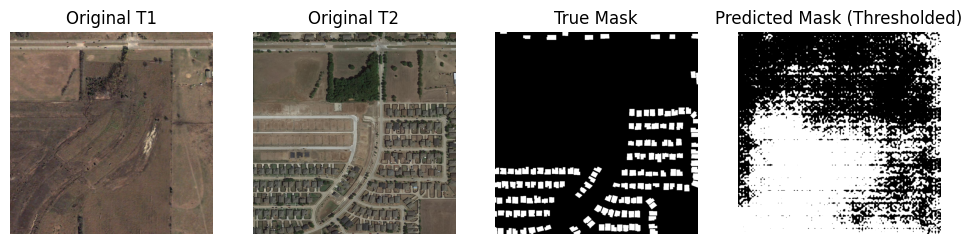

Confusion Matrix:
[[481853 438001]
 [ 42698  86024]]
Metrics:
Accuracy: 0.5416
Precision: 0.1642
Recall: 0.6683
F1 Score: 0.2636
IoU: 0.1518
MCC: 0.1261
Specificity: 0.5238
Balanced Accuracy: 0.5961
Cohen's Kappa: 0.0828


In [42]:
random_integer = random.randint(0, len(test_dset)) 
print(random_integer)
images, mask = test_dset[random_integer]['x'], test_dset[random_integer]['mask'] 
evaluate_single_image(model, images, mask)

In [ ]:
def evaluate_model_metrics(model, test_loader, device):
    model.eval() 
    running_loss = 0.0

    criterion = torch.nn.BCELoss() 
    all_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'iou': [],
        'mcc': [],
        'specificity': [],
        'balanced_accuracy': [],
        'kappa': []
    }

    c=0
    with torch.no_grad():
        for sample in test_loader:
            inputs = sample['x'].to(device) 
            labels = sample['mask'].to(device)  

            output = model(inputs)
            loss = criterion(output, labels.float())
            running_loss += loss.item()

            true_mask = labels.cpu().numpy()
            pred_mask = output.cpu().numpy()

            best_threshold, best_f1 = find_threshold(true_mask, pred_mask)
            output_binary = (output > best_threshold).int()

            accuracy, precision, recall, f1, iou, mcc, specificity, balanced_accuracy, kappa = compute_metrics(labels, output_binary)

            all_metrics['accuracy'].append(accuracy)
            all_metrics['precision'].append(precision)
            all_metrics['recall'].append(recall)
            all_metrics['f1'].append(f1)
            all_metrics['iou'].append(iou)
            all_metrics['mcc'].append(mcc)
            all_metrics['specificity'].append(specificity)
            all_metrics['balanced_accuracy'].append(balanced_accuracy)
            all_metrics['kappa'].append(kappa)
                
    avg_loss = running_loss / len(test_loader)
    avg_metrics = {metric: sum(values) / len(values) for metric, values in all_metrics.items()}

    print('Test Loss: ', avg_loss)
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    return avg_loss, avg_metrics
    
# evaluate_model_metrics(model, test_loader, device)